In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Model checking and diagnostics

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

One approach to analyzing convergence is **analytical**, whereby the
variance of the sample at different sections of the chain are compared
to that of the limiting distribution. These methods use distance metrics
to analyze convergence, or place theoretical bounds on the sample
variance, and though they are promising, they are generally difficult to
use and are not prominent in the MCMC literature. More common is a
**statistical** approach to assessing convergence. With this approach,
rather than considering the properties of the theoretical target
distribution, only the statistical properties of the observed chain are
analyzed. Reliance on the sample alone restricts such convergence
criteria to **heuristics**. As a result, convergence cannot be guaranteed.
Although evidence for lack of convergence using statistical convergence
diagnostics will correctly imply lack of convergence in the chain, the
absence of such evidence will not *guarantee* convergence in the chain.
Nevertheless, negative results for one or more criteria may provide some
measure of assurance to users that their sample will provide valid
inferences.

For most simple models, convergence will occur quickly, sometimes within
a the first several hundred iterations, after which all remaining
samples of the chain may be used to calculate posterior quantities. For
more complex models, convergence requires a significantly longer burn-in
period; sometimes orders of magnitude more samples are needed.
Frequently, lack of convergence will be caused by **poor mixing**. 
Recall that *mixing* refers to the degree to which the Markov
chain explores the support of the posterior distribution. Poor mixing
may stem from inappropriate proposals (if one is using the
Metropolis-Hastings sampler) or from attempting to estimate models with
highly correlated variables.

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 secPlotting alpha


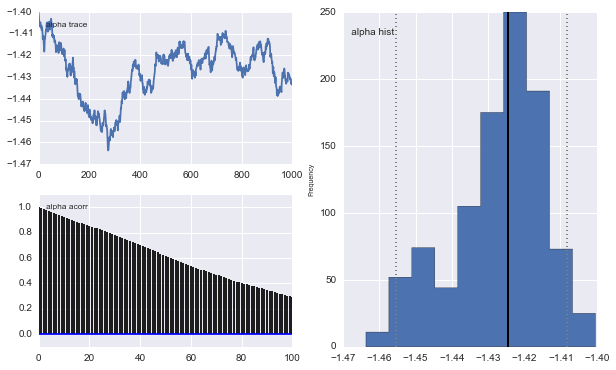

In [2]:
%matplotlib inline
from pymc.examples import gelman_bioassay
from pymc import MCMC, Matplot, Metropolis
import seaborn as sns; sns.set_context('notebook')

M = MCMC(gelman_bioassay)
M.use_step_method(Metropolis, M.alpha, scale=0.001)
M.sample(1000, tune_interval=1000)
Matplot.plot(M.alpha)

### Informal Methods

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for each of the stochastics exhibits
asymptotic behavior over the last $m$ iterations, this may be
satisfactory evidence for convergence. 

 [-----------------100%-----------------] 10000 of 10000 complete in 1.2 secPlotting beta


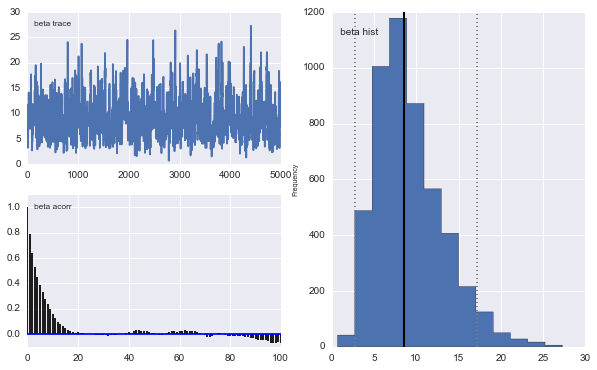

In [3]:
M = MCMC(gelman_bioassay)
M.sample(10000, burn=5000)
Matplot.plot(M.beta)

A similar approach involves
plotting a histogram for every set of $k$ iterations (perhaps 50-100)
beyond some burn in threshold $n$; if the histograms are not visibly
different among the sample intervals, this may be considered some evidence for
convergence. Note that such diagnostics should be carried out for each
stochastic estimated by the MCMC algorithm, because convergent behavior
by one variable does not imply evidence for convergence for other
variables in the analysis. 

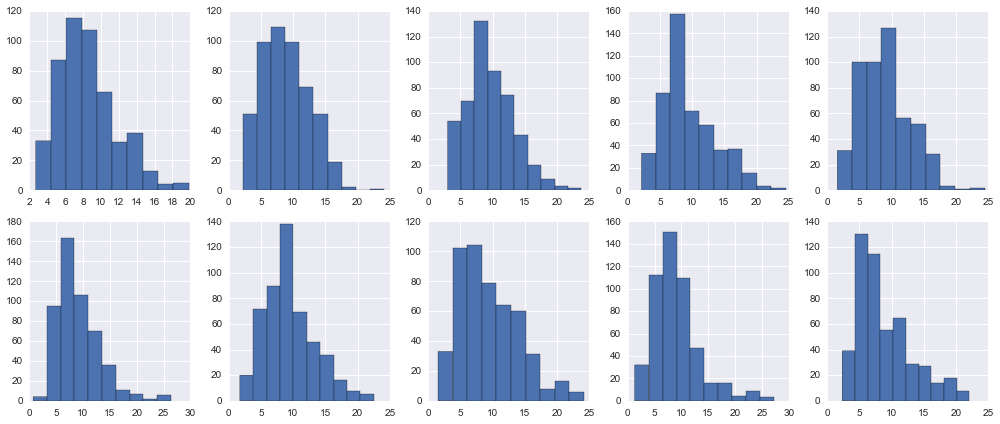

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(M.beta.trace()[500*i:500*(i+1)])
plt.tight_layout()

An extension of this approach can be taken
when multiple parallel chains are run, rather than just a single, long
chain. In this case, the final values of $c$ chains run for $n$
iterations are plotted in a histogram; just as above, this is repeated
every $k$ iterations thereafter, and the histograms of the endpoints are
plotted again and compared to the previous histogram. This is repeated
until consecutive histograms are indistinguishable.

Another *ad hoc* method for detecting lack of convergence is to examine
the traces of several MCMC chains initialized with different starting
values. Overlaying these traces on the same set of axes should (if
convergence has occurred) show each chain tending toward the same
equilibrium value, with approximately the same variance. Recall that the
tendency for some Markov chains to converge to the true (unknown) value
from diverse initial values is called *ergodicity*. This property is
guaranteed by the reversible chains constructed using MCMC, and should
be observable using this technique. Again, however, this approach is
only a heuristic method, and cannot always detect lack of convergence,
even though chains may appear ergodic.

In [5]:
from pymc.examples import disaster_model

M = MCMC(disaster_model)
M.early_mean.set_value(0.5)
M.sample(1000)
M.early_mean.set_value(5)
M.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.2 sec

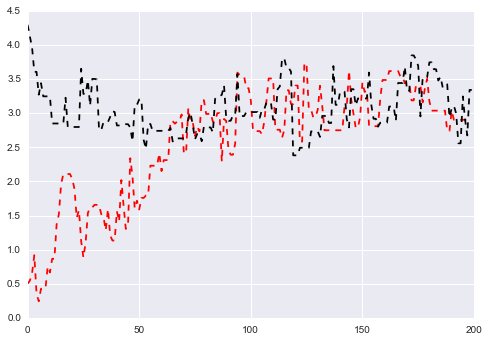

In [6]:
plt.plot(M.early_mean.trace(chain=0)[:200], 'r--')
plt.plot(M.early_mean.trace(chain=1)[:200], 'k--')

A principal reason that evidence from informal techniques cannot
guarantee convergence is a phenomenon called ***metastability***. Chains may
appear to have converged to the true equilibrium value, displaying
excellent qualities by any of the methods described above. However,
after some period of stability around this value, the chain may suddenly
move to another region of the parameter space. This period
of metastability can sometimes be very long, and therefore escape
detection by these convergence diagnostics. Unfortunately, there is no
statistical technique available for detecting metastability.

### Formal Methods

Along with the *ad hoc* techniques described above, a number of more
formal methods exist which are prevalent in the literature. These are
considered more formal because they are based on existing statistical
methods, such as time series analysis.

PyMC currently includes three formal convergence diagnostic methods. The
first, proposed by [Geweke (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011446), is a time-series approach that
compares the mean and variance of segments from the beginning and end of
a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{S_a(0) + S_b(0)}}$$

where $a$ is the early interval and $b$ the late interval, and $S_i(0)$ is the spectral density estimate at zero frequency for chain segment $i$. If the
z-scores (theoretically distributed as standard normal variates) of
these two segments are similar, it can provide evidence for convergence.
PyMC calculates z-scores of the difference between various initial
segments along the chain, and the last 50% of the remaining chain. If
the chain has converged, the majority of points should fall within 2
standard deviations of zero.

In PyMC, diagnostic z-scores can be obtained by calling the `geweke` function. It
accepts either (1) a single trace, (2) a Node or Stochastic object, or
(4) an entire Model object:

In [7]:
from pymc import geweke

M = MCMC(gelman_bioassay)
M.sample(5000)
d = geweke(M.beta, intervals=15)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.7 sec

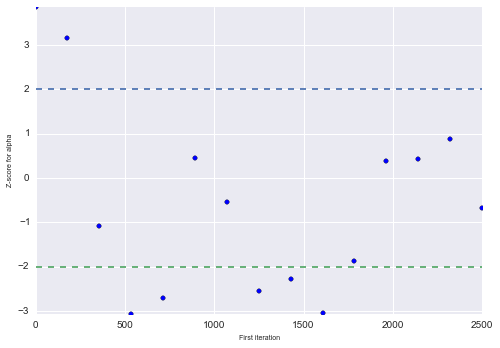

In [8]:
Matplot.geweke_plot(d, 'alpha')

The arguments expected are the following:

-   `pymc_object`: The object that is or contains the output trace(s).

-   `first` (optional): First portion of chain to be used in Geweke
    diagnostic. Defaults to 0.1 (*i.e.* first 10% of chain).

-   `last` (optional): Last portion of chain to be used in Geweke
    diagnostic. Defaults to 0.5 (*i.e.* last 50% of chain).

-   `intervals` (optional): Number of sub-chains to analyze. Defaults to
    20.

The resulting scores are best interpreted graphically, using the
`geweke_plot` function. This displays the scores in series, in relation
to the 2 standard deviation boundaries around zero. Hence, it is easy to
see departures from the standard normal assumption.

The second diagnostic provided by PyMC is the [Raftery and Lewis (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011143)
procedure. This approach estimates the number of iterations required to
reach convergence, along with the number of burn-in samples to be
discarded and the appropriate thinning interval. A separate estimate of
both quantities can be obtained for each variable in a given model.

As the criterion for determining convergence, the Raftery and Lewis
approach uses the accuracy of estimation of a user-specified quantile.
For example, we may want to estimate the quantile $q=0.975$ to within
$r=0.005$ with probability $s=0.95$. In other words,

$$Pr(|\hat{q}-q| \le r) = s$$

From any sample of $\theta$, one can construct a binary chain:

$$Z^{(j)} = I(\theta^{(j)} \le u_q)$$

where $u_q$ is the quantile value and $I$ is the indicator function.
While $\{\theta^{(j)}\}$ is a Markov chain, $\{Z^{(j)}\}$ is not
necessarily so. In any case, the serial dependency among $Z^{(j)}$
decreases as the thinning interval $k$ increases. A value of $k$ is
chosen to be the smallest value such that the first order Markov chain
is preferable to the second order Markov chain.

This thinned sample is used to determine number of burn-in samples. This
is done by comparing the remaining samples from burn-in intervals of
increasing length to the limiting distribution of the chain. An
appropriate value is one for which the truncated sample's distribution
is within $\epsilon$ (arbitrarily small) of the limiting distribution.
Estimates for sample size tend to be conservative.

This diagnostic is best used on a short pilot run of a particular model,
and the results used to parameterize a subsequent sample that is to be
used for inference. 

In [9]:
from pymc import raftery_lewis

M = MCMC(gelman_bioassay)
M.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

In [10]:
raftery_lewis(M.alpha, q=0.025, r=0.01)


Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

41 iterations to be discarded at the beginning of the simulation (burn-in).

11356 subsequent iterations required.

Thinning factor of 6 required to produce an independence chain.


(937, 1, 41, 11356, 6)

The arguments are:

-   `pymc_object`: The object that contains the Geweke scores. Can be a
    list (one set) or a dictionary (multiple sets).

-   `q`: Desired quantile to be estimated.

-   `r`: Desired accuracy for quantile.

-   `s` (optional): Probability of attaining the requested accuracy
    (defaults to 0.95).

-   `epsilon` (optional) : Half width of the tolerance interval required
    for the q-quantile (defaults to 0.001).

The third convergence diagnostic provided by PyMC is the Gelman-Rubin
statistic [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. In PyMC, the function
`gelman_rubin` will calculate $\hat{R}$ for each stochastic node in
the passed model:

In [11]:
from pymc import gelman_rubin

M = MCMC(gelman_bioassay)
M.sample(1000)
M.sample(1000)
M.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

In [12]:
gelman_rubin(M)

{'LD50': 1.022305808882138,
 'alpha': 1.0456710813287029,
 'beta': 1.0334414006577364,
 'theta': [1.0113564513289881,
  1.0016109728200859,
  1.0359350048788907,
  1.0139190372451301]}

For the best results, each chain should be initialized to highly
dispersed starting values for each stochastic node.

By default, when calling the `summary_plot` function using nodes with
multiple chains, the $\hat{R}$ values will be plotted alongside the
posterior intervals.

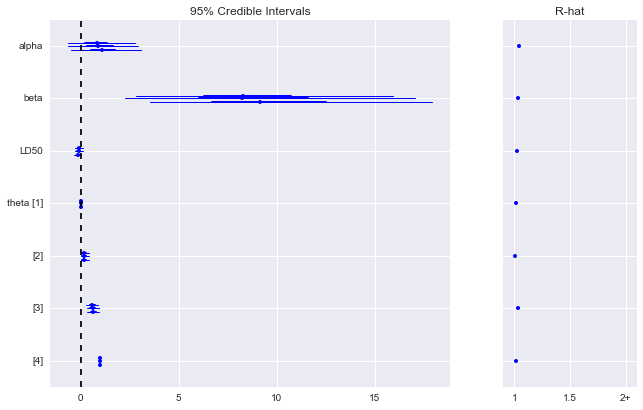

In [13]:
plt.figure(figsize=(10,6))
Matplot.summary_plot(M)

## Goodness of Fit

Checking for model convergence is only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model
to converge, so additional steps are needed to ensure that the estimated
model adequately fits the data. One intuitive way of evaluating model
fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate
data, and the distribution of the simulated data should resemble the
distribution of the actual data.

Fortunately, simulating data from the model is a natural component of
the Bayesian modelling framework. Recall, from the discussion on
imputation of missing data, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be
expected, taking into account the posterior uncertainty in the model
parameters. Sampling from the posterior predictive distribution is easy
in PyMC. The code looks identical to the corresponding data stochastic,
with two modifications: (1) the node should be specified as
deterministic and (2) the statistical likelihoods should be replaced by
random number generators. Consider the `gelman_bioassay` example, 
where deaths are modeled as a binomial random variable for which
the probability of death is a logit-linear function of the dose of a
particular drug.

In [14]:
from pymc import Normal, Binomial, deterministic, invlogit

n = [5]*4 
dose = [-.86,-.3,-.05,.73] 
x = [0,1,3,5]

alpha = Normal('alpha', mu=0.0, tau=0.01) 
beta = Normal('beta', mu=0.0, tau=0.01)

@deterministic 
def theta(a=alpha, b=beta, d=dose):
    """theta = inv_logit(a+b)""" 
    return invlogit(a+b*d)

# deaths ~ binomial(n, p)
deaths = Binomial('deaths', n=n, p=theta, value=x, observed=True)

The posterior predictive distribution of deaths uses the same functional
form as the data likelihood, in this case a binomial stochastic. Here is
the corresponding sample from the posterior predictive distribution:

In [15]:
deaths_sim = Binomial('deaths_sim', n=n, p=theta)

Notice that the observed stochastic `Binomial` has been replaced
with a stochastic node that is identical in every respect to \`deaths\`,
except that its values are not fixed to be the observed data -- they are
left to vary according to the values of the fitted parameters.

The degree to which simulated data correspond to observations can be
evaluated in at least two ways. First, these quantities can simply be
compared visually. This allows for a qualitative comparison of
model-based replicates and observations. If there is poor fit, the true
value of the data may appear in the tails of the histogram of replicated
data, while a good fit will tend to show the true data in
high-probability regions of the posterior predictive distribution.
The Matplot package in PyMC provides an easy way of producing such
plots, via the `gof_plot` function.

In [16]:
M_gof = MCMC([alpha, beta, theta, deaths, deaths_sim])
M_gof.sample(2000, 1000)

 [-----------------100%-----------------] 2000 of 2000 complete in 0.6 sec

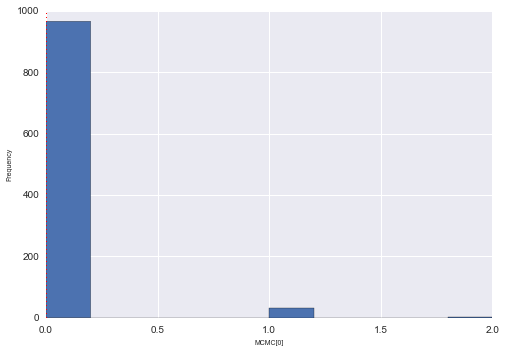

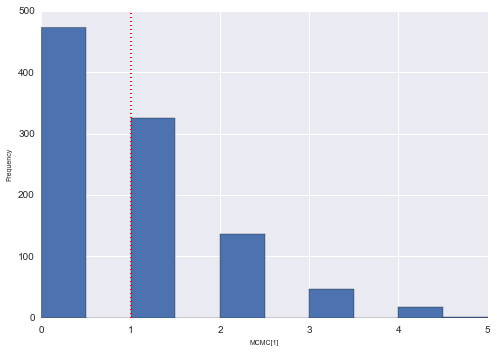

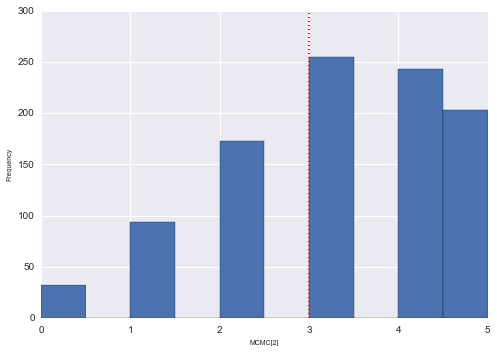

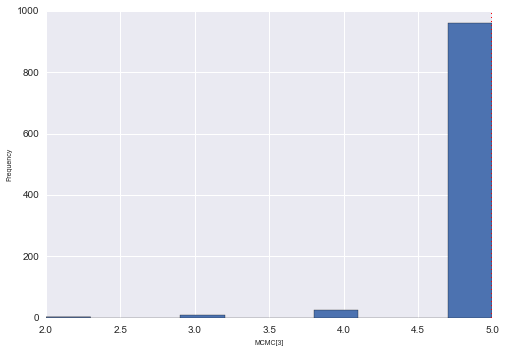

In [17]:
Matplot.gof_plot(deaths_sim.trace(), x, bins=10)

A second approach for evaluating goodness of fit using samples from the
posterior predictive distribution involves the use of a statistical
criterion. For example, the Bayesian p-value [(Gelman et al. 1996)](http://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/GelmanMengStern1996.pdf) uses a
discrepancy measure that quantifies the difference between data
(observed or simulated) and the expected value, conditional on some
model. One such discrepancy measure is the Freeman-Tukey statistic
[(Brooks et al. 2000)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1009213003):

$$D(x|\theta) = \sum_j (\sqrt{x_j}-\sqrt{e_j})^2,$$

where the $x_j$ are data and $e_j$ are the corresponding expected
values, based on the model. Model fit is assessed by comparing the
discrepancies from observed data to those from simulated data. On
average, we expect the difference between them to be zero; hence, the
Bayesian *p* value is simply the proportion of simulated discrepancies
that are larger than their corresponding observed discrepancies:

$$p = Pr[ D(x_{\text{sim}}|\theta) > D(x_{\text{obs}}|\theta) ]$$

If $p$ is very large (e.g. $>0.975$) or very small (e.g. $\lt 0.025$) this
implies that the model is not consistent with the data, and thus is
evidence of lack of fit. Graphically, data and simulated discrepancies
plotted together should be clustered along a 45 degree line passing
through the origin.

The `discrepancy` function in the `diagnostics` package can be used to
generate discrepancy statistics from arrays of data, simulated values,
and expected values:

    D = pymc.discrepancy(x, x_sim, x_exp)

In [18]:
from pymc import discrepancy

expected = theta.trace
d = discrepancy(x, deaths_sim, (theta.trace() * n).T)
d[0][:10], d[1][:10]

Bayesian p-value: p=0.641


(array([ 8.41179637,  8.88347882,  8.66875059,  8.81390783,  8.5990759 ,
         8.62489171,  8.74359478,  8.22683857,  8.37631805,  8.01903152]),
 array([  4.89055335,   8.93671764,   8.72098457,   8.81390783,
          8.5990759 ,   6.72273228,   7.82132816,   9.23311234,
         10.32817546,   9.92365125]))

For a dataset of size $n$ and an MCMC chain of length $r$, this implies
that `x` is size `(n,)`, `x_sim` is size `(r,n)` and `x_exp` is either
size `(r,)` or `(r,n)`. A call to this function returns two arrays of
discrepancy values (simulated and observed), which can be passed to the
`discrepancy_plot` function in the \`Matplot\` module to generate a
scatter plot, and if desired, a *p* value:

Plotting discrepancy-gof


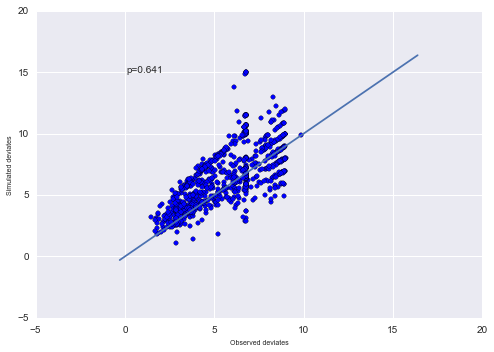

In [19]:
Matplot.discrepancy_plot(d)

## Exercise: Meta-analysis of beta blocker effectiveness

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction.

In a random effects meta-analysis we assume the true effect (on a log-odds scale) $d_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$,
and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta_i \\
\delta_i &\sim \text{Normal}(d, t) \\
\mu_i &\sim \text{Normal}(m, s)
\end{aligned}$$

We want to make inferences about the population effect $d$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. Build a model to estimate these quantities in PyMC, and (1) use convergence diagnostics to check for convergence and (2) use posterior predictive checks to assess goodness-of-fit.

Here are the data:

In [20]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [21]:
# Write your answer here

## Reading Assigment

[Gelman A, Shalizi CR](http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf) (2013). Philosophy and the practice of Bayesian statistics. Br J Math Stat Psychol. 66, 8–38.


## References

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

Geweke, J., Berger, J. O., & Dawid, A. P. (1992). Evaluating the accuracy of sampling-based approaches to the calculation of posterior moments. In Bayesian Statistics 4.

Brooks, S. P., Catchpole, E. A., & Morgan, B. J. T. (2000). Bayesian Animal Survival Estimation. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 15(4), 357–376. doi:10.1214/ss/1177010123

Gelman, A., Meng, X., & Stern, H. (1996). Posterior predicitive assessment of model fitness via realized discrepencies with discussion. Statistica Sinica, 6, 733–807.

Raftery, A., & Lewis, S. (1992). One long run with diagnostics: Implementation strategies for Markov chain Monte Carlo. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 7, 493–497.

[CrossValidated: How to use scikit-learn's cross validation functions on multi-label classifiers](http://stats.stackexchange.com/questions/65828/how-to-use-scikit-learns-cross-validation-functions-on-multi-label-classifiers)